In [1]:
#import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp


from juniper.Gaussian import Gaussian
from juniper.LateralKernel import LateralKernel

from juniper.steps.NeuralField import NeuralField
from juniper.steps.StaticGain import StaticGain
from juniper.steps.DemoInput import DemoInput
from juniper.steps.TimedBoost import TimedBoost
from juniper.steps.Projection import Projection
from juniper.steps.Sum import Sum


from demo.demo_corsi import demo_corsi_query

In [2]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CpuDevice(id=0)]


In [3]:
arch = jp.Architecture.get_arch()

<img src="demo/img/corsi_query.drawio.png" alt="drawing" width="600"/>

In [4]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()
shape = (294, 447)
denom_gi = shape[0] * shape[1]

### Static steps
# input and attention, transient detector
boost_memorize = TimedBoost("boost_mem", {"amplitude":4, "duration": [0, 3]}) # 150 steps * 0.02msec
boost_query = TimedBoost("boost_query", {"amplitude":3, "duration": [3.2, 6]})
demo_inputs = [DemoInput("in"+str(i), {"shape":shape, "sigma":(8,8), "amplitude":0, "center": (0,0)}) for i in range(4)]
start_bias = TimedBoost("biasordinal", {"amplitude":1, "duration": [0, 99]}) # use as constant bias input
proj0 = Projection("proj0", {"input_shape":shape, "output_shape":(1,), "axis":(0,1), "order":(), "compression_type": "Maximum"})                   
st6 = StaticGain("st6", {"factor": 6})
st4 = StaticGain("st4", {"factor": -6})
# mental maps
st0 = StaticGain("st0", {"factor": 3})
st2s = []
[st2s.append(StaticGain(f"st2_{i}", {"factor": 3})) for i in range(4)] 
# int and cos
st3 = StaticGain("st3", {"factor": 8})
proj61 = Sum("proj61", {})
st5 = StaticGain("st5", {"factor": 3})
st8 = StaticGain("st8", {"factor": -20})
st7 = StaticGain("st7", {"factor": 3})
st65s = []
[st65s.append(StaticGain(f"st65_{i}", {"factor": 2})) for i in range(4)] 
proj110s = []
[proj110s.append(Projection(f"proj110_{i}", {"input_shape":shape, "output_shape":(1,), "axis":(0,1), "order":(), "compression_type": "Maximum"})) for i in range(4)]
st99s = []
[st99s.append(StaticGain(f"st99_{i}", {"factor": 4})) for i in range(4)]
# ordinal machinery
st_cos_ord = StaticGain("stco", {"factor": -30})
st131 = StaticGain("st131", {"factor": 10})
st45 = StaticGain("st45", {"factor": 15})
stmo = []
stom = []
stmo1 = []
lat_io = []
for i in range(4):
    stmo.append(StaticGain(f"stm{i}o{i}", {"factor": -5}))
    stom.append(StaticGain(f"sto{i}m{i}", {"factor": 10}))
    lat_io.append(StaticGain(f"latio{i}", {"factor": -20}))
for i in range(3):
    stmo1.append(StaticGain(f"stm{i}o{i+1}", {"factor": 10}))
# querying
st9s = []
[st9s.append(StaticGain(f"st9_{i}", {"factor": 3})) for i in range(4)] 
query_inputs = []
[query_inputs.append(DemoInput("query"+str(i), {"shape":(1,), "sigma":(999999,), "amplitude":0, "center": (0,)})) for i in range(4)]
proj2 = Sum("proj2", {})
st13 = StaticGain("st13", {"factor": 6})
stlast = StaticGain("stlast", {"factor": 3})


### field params
att_exc_kernel = Gaussian({"sigma": (7,7), "amplitude": 6, "normalized": True})
node_exc_kernel = Gaussian({"sigma": (0.01,), "amplitude": 1, "normalized": True})
node_ord_kernel = Gaussian({"sigma": (0.01,), "amplitude": 2, "normalized": True})
node_mem_kernel = Gaussian({"sigma": (0.01,), "amplitude": 10, "normalized": True})
mem_exc_kernel = Gaussian({"sigma": (4,4), "amplitude": 200, "normalized": True})
mem_inh_kernel = Gaussian({"sigma": (7,7), "amplitude": -192, "normalized": True})
mem_kernel = LateralKernel({"kernels": [mem_exc_kernel, mem_inh_kernel]})

### Dynamic steps
# attention field and transient detector
field_atn = NeuralField(f"nf_atn", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})
transient_u = NeuralField(f"u", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})
transient_v = NeuralField(f"v", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.3, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})  # slow time scale
# mental maps
field_maps = []
[field_maps.append(NeuralField(f"map{i}", {"shape": shape, "resting_level": -5, "global_inhibition": -0.01, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": mem_kernel})) for i in range(4)]
# ordinal machine
ordinal_nodes = []
[ordinal_nodes.append(NeuralField(f"ord{i}", {"shape": (1,), "resting_level": -20, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})) for i in range(4)]
memory_nodes = []
[memory_nodes.append(NeuralField(f"mem{i}", {"shape": (1,), "resting_level": -1, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_ord_kernel})) for i in range(4)]
# intention and cos
intention_node = NeuralField(f"int", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_mem_kernel})
cos_node = NeuralField(f"cos", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})
cos_detectors = []
[cos_detectors.append(NeuralField(f"cosfield{i}", {"shape": (1,), "resting_level": -5, "global_inhibition": 0.0, "tau": 0.06, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": node_exc_kernel})) for i in range(4)]
# querying and execution
field_readouts = []
[field_readouts.append(NeuralField(f"readout{i}", {"shape": shape, "resting_level": -5, "global_inhibition": -0.00016, "tau": 0.05, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})) for i in range(4)]
field_hand = NeuralField(f"nf1", {"shape": shape, "resting_level": -5, "global_inhibition": -0.0001, "tau": 0.1, 
                    "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0,
                    "lateral_kernel_convolution": att_exc_kernel})


### connections
# input, attention and transient detection
[demo_inputs[i] >> field_atn for i in range(4)]
field_atn >> proj0
proj0 >> st6
st6 >> transient_u
st6 >> transient_v
transient_v >> st4
st4 >> transient_u
# int and cos
boost_memorize >> intention_node
transient_u >> st3
st3 >> intention_node
[cos_detectors[i] >> proj61 for i in range(4)]
proj61 >> st5
st5 >> cos_node
intention_node >> st7
st7 >> cos_node
cos_node >> st8
st8 >> intention_node
# cos detectors
[ordinal_nodes[i] >> st65s[i] for i in range(4)]
[st65s[i] >> cos_detectors[i] for i in range(4)]
[field_maps[i] >> proj110s[i] for i in range(4)]
[proj110s[i] >> st99s[i] for i in range(4)]
[st99s[i] >> cos_detectors[i] for i in range(4)]
# ordinal machine
cos_node >> st_cos_ord
[st_cos_ord >> ordinal_nodes[i] for i in range(4)]
start_bias >> st131
st131 >> ordinal_nodes[0]
intention_node >> st45
[st45 >> ordinal_nodes[i] for i in range(4)]
[memory_nodes[i] >> stmo[i] for i in range(4)]
[stmo[i] >> ordinal_nodes[i] for i in range(4)]
[ordinal_nodes[i] >> stom[i] for i in range(4)]
[stom[i] >> memory_nodes[i] for i in range(4)]
[memory_nodes[i] >> stmo1[i] for i in range(3)]
[stmo1[i] >> ordinal_nodes[i+1] for i in range(3)]
[ordinal_nodes[i] >> lat_io[i] for i in range(4)]
[lat_io[i] >> ordinal_nodes[j] for i in range(4) for j in range(4) if j != i]
# mental map
[ordinal_nodes[i] >> st2s[i] for i in range(4)]
[st2s[i] >> field_maps[i] for i in range(4)]
field_atn >> st0
[st0 >> field_maps[i] for i in range(4)]
# querying and execution
[field_maps[i] >> st9s[i] for i in range(4)]
[st9s[i] >> field_readouts[i] for i in range(4)]
[query_inputs[i] >> field_readouts[i] for i in range(4)]
[field_readouts[i] >> proj2 for i in range(4)]
proj2 >> st13
st13 >> field_atn
field_atn >> stlast
stlast >> field_hand
boost_query >> field_hand

arch.compile()

Loading saved buffers...


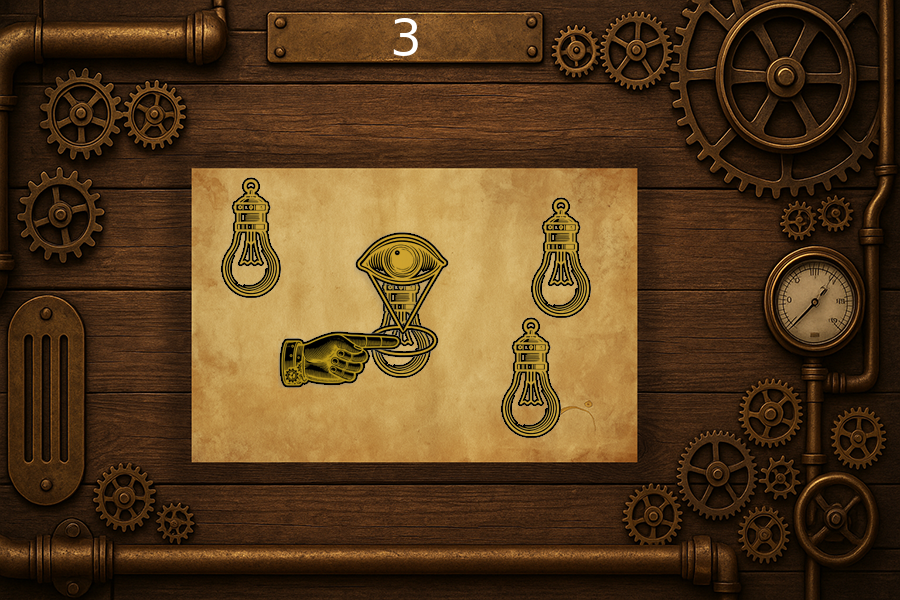

In [5]:
num_steps = 200
demo = demo_corsi_query(arch, eye_field="nf_atn", hand_field="nf1")
recording = demo.run(num_steps)

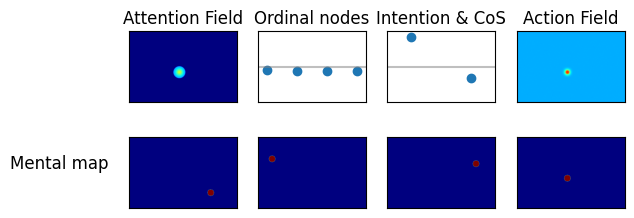

In [6]:
demo.plot()